In [1]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Suppresses gensim errors

### Things I've installed:
1. wikipedia (query wikipedia) - not used
2. pywikibot (more advanced queries)
3. wikiutils (read sql.gz files) - not yet used. possibly in the future
4. gensim (for NLP and specifically using Google's word2vec)

### Load word2vec embeddings

In [2]:
# Obviously override this to your local location
#model_addr = '/Users/benjaminrafetto/Code/cs182/project/data/GoogleNews-vectors-negative300.bin'

# claire's address 
model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)  

### Crude definition of distance

In [4]:
# Currently uses average word distances from word2vec embeddings
def get_distance_new(topic, model, goal):
    assert type(topic) is list and type(goal) is list
    try:
        distances = [model.distance(x, y) for x in topic for y in goal]
        return (np.average(distances) + np.min(distances) / 2.0)  # Combination of average and minimum
    except:
        return np.Infinity


### Connect to Wikipedia

In [5]:
site = pywikibot.Site("en", "wikipedia")

In [6]:
def greedy_word2vec_path(start, goal, maxIters=30, verbose=False):
    start_list = process_word(start)
    goal_list = process_word(goal)
    assert get_distance_new(start_list, model, goal_list) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if p.title() not in visited:
                visited.append(p.title())
                processed = process_word(p.title())
#                 print(p.title(), processed)
                distance = get_distance_new(processed, model, goal_list)
                fringe.put((distance, p))

    return []
#     raise Exception("Unable to find goal node.")

In [7]:
def process_word(topic, model=model):
    if not topic:  #No topic. Stop.
        return []
    
    if topic in model:
        return [topic]

    output = []
    words = topic.split(' ')

    #Iteratively search word2vec for shorter and shorter phrases
    for j in range(len(words), 1, -1):
        test = '_'.join(words[:j])
        if test in model:
            return [test] + process_word(' '.join(words[j:]))

    if words[0] in model:
        output.append(words[0])
    return output + process_word(' '.join(words[1:]))

### Test algorithm

In [20]:
examples = [("speech", "lacrosse"),
            ("mantra", "dna"),
            ("Parthenon", "Natural Environment"),
            ("Feces", "Poet"),
#             ("penguin", "sans-serif"),  #sans-serif is not in the dictionary
            ("angelina jolie", "nitrogen"),
            ("Carrie Fisher", "Death of Adolf Hitler"),
            ("Lacrosse", "Comedian"),
            ("Dictionary", "Atmosphere of Earth"),
            ("Broadway theatre", "Wall Street"),
            ("Life expectancy", "Graphical User Interface"),
            ("Diazepam", "Death"),
            ("Moors", "Aryan"),
            ("Michelangelo", "Horror Fiction"),
            ("Jim Henson", "Gin"),
            ("Continental Army", "Computer Multitasking"),
            ("World Health Organization", "Ecosystem"),
            ("Blood pressure", "Mathematics"),
            ("War of 1812", "Queens of the Stone Age"),
            ("Onomatopoeia", "Wiki"),
            ("Church of England", "Joan Baez"),
            ("Nuclear Power", "Canadians"),
            ("Multi-sport event", "Ku Klux Klan"),
            ("Pony Express", "Augustus"),
            ("Organization", "Parthenon"),
            ("Battleship", "Dream"),
            ("The Cosby Show", "Marine biology"),
            ("DNA replication", "Muscle car"),
            ("Mammal", "Montreal"),
            ("River", "Engine"),
            ("Louis Armstrong", "Nuclear Power"),
            ("Entertainment", "Ralph Waldo Emerson"),
            ("Bilirubin", "Architecture"),
            ("Association football", "Axis powers"),
            ("World Series", "Nuclear warfare"),
            ("Sherlock Holmes","Magnetic resonance imaging"),
            ("Waterboarding","World War II"),
            ("World Trade Organization", "Ant"),
            ("Printed circuit board", "Typhoid fever"),
            ("Statistics","Renaissance"),
            ("Radio","Personal computer"),
            ("Bette Midler","Jellyfish"),
            ("Sigmund Freud","Vacuum"),
            ("Credit card","String theory"),
            ("Radiohead","Magnetic field"),
            ("Biosphere","Nobel Prize in Physiology or Medicine"),
            ("Mick Jagger","Knife"),
            ("West Indies","Gastroesophageal reflux disease"),
            ("Wesley Snipes","Computer science"),
            ("Airline","Bavaria"),
            ("Nevada","Maltose")
           ]

In [21]:
start, goal = examples[np.random.choice(len(examples))]
print("Searching for shortest path from {} to {}".format(start,goal))

Searching for shortest path from World Series to Nuclear warfare


### To-Do: exclude Wikipedia: Category: Talk:

### Generate data for greedy search:

In [19]:
for start, goal in examples[-1:]:
    path = greedy_word2vec_path(start, goal, maxIters=50, verbose=False)
    print("Length", len(path), "Path", path)

Length 4 Path ['Statistics', 'Medieval Roman law', 'Early Middle Ages', 'Renaissance']


In [25]:
# get path length for 50 samples
path_lengths = []
paths = []
for start, goal in examples:
    print("start: {}, goal: {}".format(start,goal))
    path = greedy_word2vec_path(start, goal, maxIters=50, verbose=False)
    paths.append(path)
    path_lengths.append(len(path))

start: speech, goal: lacrosse
start: mantra, goal: dna
start: Parthenon, goal: Natural Environment
start: Feces, goal: Poet
start: angelina jolie, goal: nitrogen
start: Carrie Fisher, goal: Death of Adolf Hitler
start: Lacrosse, goal: Comedian
start: Dictionary, goal: Atmosphere of Earth
start: Broadway theatre, goal: Wall Street
start: Life expectancy, goal: Graphical User Interface
start: Diazepam, goal: Death
start: Moors, goal: Aryan
start: Michelangelo, goal: Horror Fiction
start: Jim Henson, goal: Gin
start: Continental Army, goal: Computer Multitasking
start: World Health Organization, goal: Ecosystem
start: Blood pressure, goal: Mathematics
start: War of 1812, goal: Queens of the Stone Age
start: Onomatopoeia, goal: Wiki
start: Church of England, goal: Joan Baez
start: Nuclear Power, goal: Canadians
start: Multi-sport event, goal: Ku Klux Klan
start: Pony Express, goal: Augustus
start: Organization, goal: Parthenon
start: Battleship, goal: Dream
start: The Cosby Show, goal: Mar

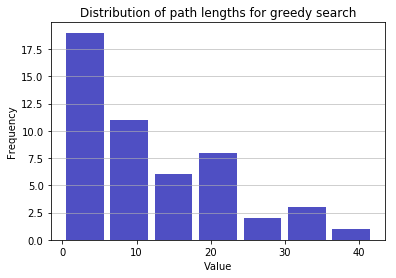

In [33]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=path_lengths, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of path lengths for greedy search')
#maxfreq = n.max()
plt.show()